In [ ]:
# /content/drive/MyDrive/Practice Notebook/Song Recommender/song_data.csv

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Practice Notebook/Song Recommender/song_data.csv')
df.head()

,user_id,song_id,listen_count,title,artist,song
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Jack Johnson,The Cove - Jack Johnson
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Paco De Lucia,Entre Dos Aguas - Paco De Lucia
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Kanye West,Stronger - Kanye West
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,Jack Johnson,Constellations - Jack Johnson
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,Foo Fighters,Learn To Fly - Foo Fighters


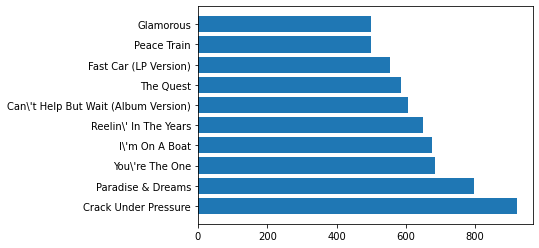

In [3]:
best_songs = df.sort_values('listen_count', ascending = False).head(10)
counter_pos = np.arange(len(best_songs))
counts = best_songs['listen_count']
counter_labels = best_songs['title']
plt.barh(counter_pos, counts)
plt.yticks(counter_pos, counter_labels)
plt.show()

In [4]:
users = df['user_id'].unique()
len(users)

66346

In [5]:
most_listeners = df.groupby('song')['user_id'].agg('count').to_frame('count').sort_values('count', ascending = False)
most_listeners

,count
song,
Sehr kosmisch - Harmonia,5970
Undo - Björk,5281
You\'re The One - Dwight Yoakam,4806
Dog Days Are Over (Radio Edit) - Florence + The Machine,4536
Revelry - Kings Of Leon,4339
...,...
Accidntel Deth (Album Version) - Rilo Kiley,16
Trahison - Vitalic,15
Marching Theme - Neutral Milk Hotel,15


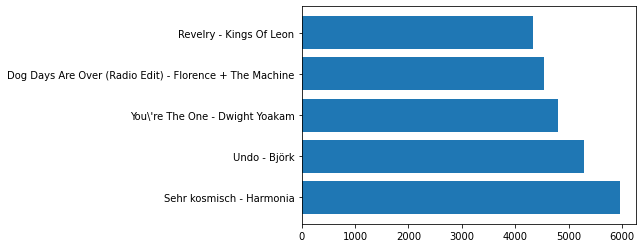

In [7]:
most_listeners = most_listeners.head()
counter_pos = np.arange(len(most_listeners))
counts = most_listeners['count']
counter_labels = most_listeners.index
plt.barh(counter_pos, counts)
plt.yticks(counter_pos, counter_labels)
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size = 0.8, test_size = 0.2, random_state = 0)

In [9]:
popularity = df.groupby('song')['listen_count'].agg('sum').to_frame('total').sort_values('total', ascending = False)
popularity.head()

,total
song,
You\'re The One - Dwight Yoakam,40619
Undo - Björk,36059
Revelry - Kings Of Leon,30391
Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile) - Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner,21953
Sehr kosmisch - Harmonia,21646


In [10]:
song_data_grouped = df.groupby('song')['user_id'].agg(lambda x: ' '.join(x.values))
song_data_grouped.head()

song
#!*@ You Tonight [Featuring R. Kelly] (Explicit Album Version) - The Notorious B.I.G.    9236fe7fcb3905ea0daf49408f15a3c8b085b094 83ec2...
#40 - DAVE MATTHEWS BAND                                                                 b55d68f1a8759157038eb6688e5d6bb1b6336567 caa19...
& Down - Boys Noize                                                                      bab8d135cf88852063ed4a084dd24c783d7ff841 e22fc...
(Anaesthesia) Pulling Teath - Metallica                                                  8ee90038724c4957eb4df16f3e9c6ed2b570a3ec b963b...
(Antichrist Television Blues) - Arcade Fire                                              a7c4e5316026288c499a59ff03d8732d58206c92 ba230...
Name: user_id, dtype: object

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
values = CountVectorizer(max_features = 1000).fit_transform(song_data_grouped.values)
dense_values = values.todense()
dense_values.shape

(9952, 1000)

In [12]:
from scipy.spatial.distance import cdist
similarity = cdist(dense_values, dense_values, 'jaccard')
similarity.shape

(9952, 9952)

In [13]:
def retrieve_similar_items(id):
  return np.argsort(similarity[id])[:11]

In [15]:
print('{}'.format('\n'.join(song_data_grouped.index[retrieve_similar_items(2000)])))

Dirt Off Your Shoulder - Jay-Z
What\'s My Name - DMX
Shake Down - Akon
Houstatlantavegas - Drake
Bitch Please (Explicit) (Feat. Xzibit) - Snoop Dogg Featuring Xzibit
Air Force Ones - Nelly / David Banner / 8-Ball
What\'s The Difference - Dr. Dre / Eminem / Alvin Joiner
White City - The Pogues
Hotel St. George - The Hassles Feat. Billy Joel
We Fly High - Jim Jones
Whatever - Hypasonic


In [ ]:
song_lookup_dict = {name: i for i, name in enumerate(song_data_grouped.index)}
song_lookup_dict

In [47]:
def congregate_song(row, values_kept=20):
    songs_data = similarity[row["song"]]
    song_and_listen = songs_data * np.expand_dims(row["listen_count"], axis=1)
    song_and_listen = np.argsort(np.sum(song_and_listen, axis=0))
    #print(song_and_listen.shape)
    if(values_kept is not None and values_kept != 0):
        return song_and_listen[:values_kept]
    else:
        return song_and_listen

In [48]:
def recommend(users, song_number=20):
    # filter the data
    users_data_id = df["user_id"].isin(users)
    users_data = df.loc[users_data_id].groupby("user_id")["song", "listen_count"].agg({
        "song": lambda x: np.vectorize(song_lookup_dict.get)(x.values).tolist(),
        "listen_count": lambda x: x.values.tolist()
    })

    users_data["recommend"] = users_data.apply(lambda x: congregate_song(x, values_kept=song_number), axis=1)
    return users_data

In [49]:
def show_songs_list(users_data):
    #users_data.reindex(columns=["song", "listen_count"])
    for row in users_data.iterrows():
        print("User {:s}'s recommended songs:'\n{:s}".format(
            row[0], 
            "\n".join( (song_data_grouped.index[song_id] for song_id in row[-1]["recommend"]))
        ))

In [50]:
show_songs_list(recommend(users=[users[0]]))

User b80344d063b5ccb3212f76538f3d9e43d87dca9e's recommended songs:'
Moonshine - Jack Johnson
Behind The Sea [Live In Chicago] - Panic At The Disco
I\'ll Be Missing You (Featuring Faith Evans & 112)(Album Version) - Puff Daddy
I?\'m A Steady Rollin? Man - Robert Johnson
Por La Noche - Mala Rodriguez
Apuesta Por El Rock \'N\' Roll - Héroes del Silencio
Ya No Sos Igual - 2 Minutos
Bigger Isn\'t Better - The String Cheese Incident
The Cove - Jack Johnson
Constellations - Jack Johnson
Holes To Heaven - Jack Johnson
Héroe De Leyenda - Héroes del Silencio
Love Song For No One - John Mayer
People Watching - Jack Johnson
Ghost Dream - Hymie\'s Basement
Neon - John Mayer
Danse Pour Moi - M. Pokora
Flashdance... What A Feeling - Irene Cara
B.I.G. (Interlude)(Amended Version) - The Notorious B.I.G.
The Message/ Outro - Dr. Dre / Thomas Chong / Mary J. Blige / Rell


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


In [51]:
song_lookup_dict['With Or Without You - U2']

9652